# 프로젝트 시행
## 1-1 
### 데이터 준비

In [1]:
from skimage import data
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import numpy as np

In [2]:
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
        # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Memory growth must be set before GPUs have been 
             print(e)

init_gpu()

1 Physical GPUs, 1 Logical GPUs


먼저 저화질/고화질 고양이 사진을 준비한다. 

In [3]:
path = "/home/aiffel-dj15/aiffel/super_resolution/"
high_image_name = "lulu.jpg"
low_image_name = "lulu_walking.jpg"
# 저화질 데이터
high_image = np.asarray(Image.open(path + high_image_name))
# 고화질 데이터
low_image = np.asarray(Image.open(path + low_image_name))
print(high_image.shape)
print(low_image.shape)

(720, 1280, 3)
(497, 533, 3)


(180, 320, 3)


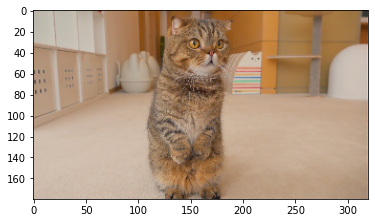

In [4]:
high_image_shape = high_image.shape[:2]
low_image_shape = low_image.shape[:2]
#shape는 세로,가로 -> cv2는 가로,세로로 명시한다. 
lower_high_image = cv2.resize(high_image, dsize = (high_image_shape[1]//4,high_image_shape[0]//4),interpolation=cv2.INTER_CUBIC)
#higher_low_image = cv2.resize(high_image, dsize = (low_image_shape[1]*4,low_image_shape[0]*4))
plt.imshow(lower_high_image)
print(lower_high_image.shape)

### 미리 학습된 SRGAN 모델 적용하기

In [5]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]
srgan_hr = apply_srgan(lower_high_image)
print(srgan_hr.shape)

(720, 1280, 3)


In [6]:
srgan_hr_bicubic_image = cv2.resize(
    srgan_hr, 
    dsize=(high_image_shape[1],high_image_shape[0]), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

### 결과 비교

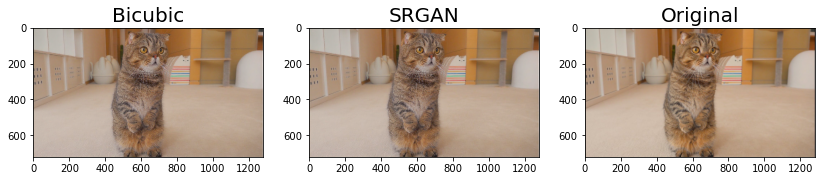

In [7]:
titles = ["Bicubic", "SRGAN", "Original"]
images = [srgan_hr_bicubic_image, srgan_hr, high_image]
plt.figure(figsize=(14,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

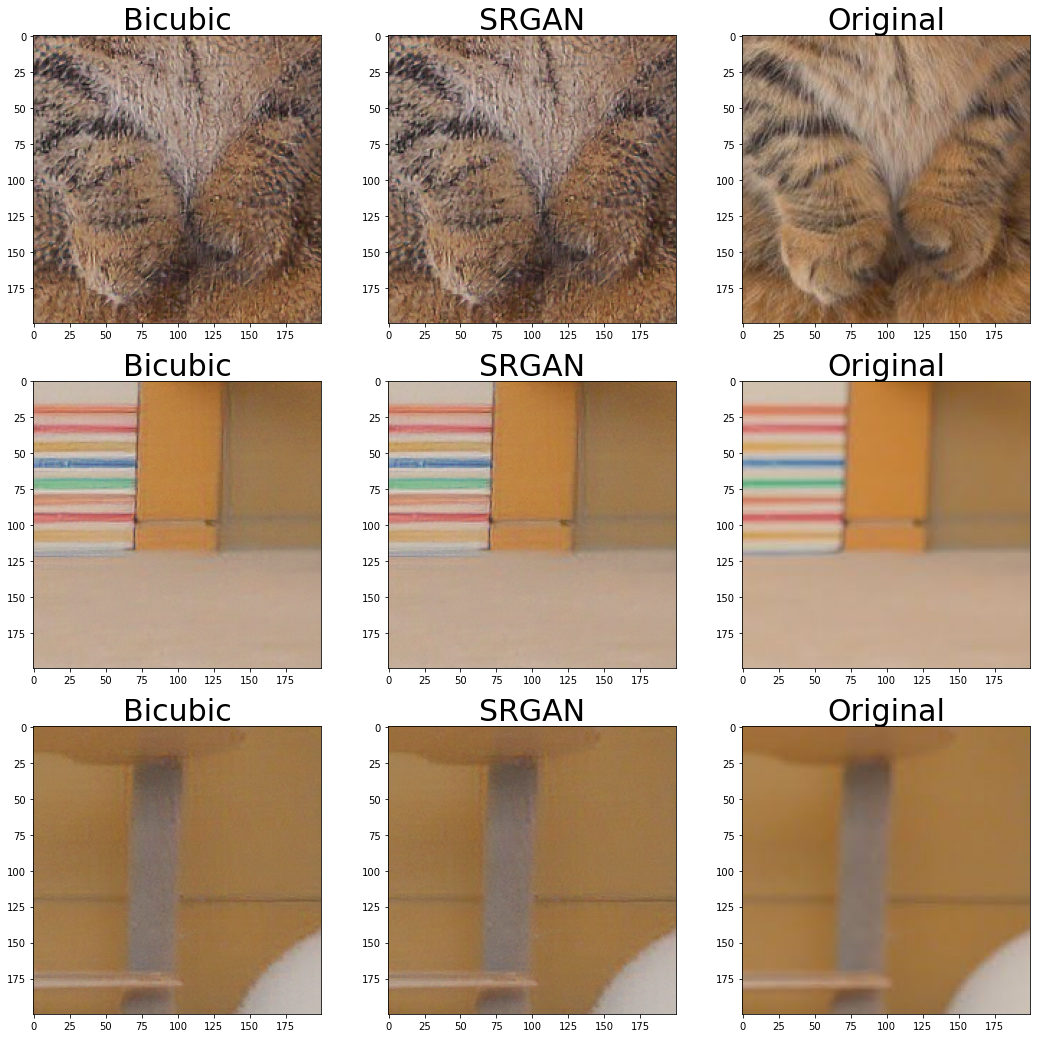

In [8]:
left_tops = [(400,500), (200,800), (0,1000)]

images = [srgan_hr_bicubic_image, srgan_hr, high_image]
point_crops=[]

def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

for left_top in left_tops:
    img1 = crop(images[0], left_top, 200, 200)
    img2 = crop(images[1] , left_top, 200, 200)
    img3 = crop(images[2], left_top, 200, 200)
    point_crops.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "Original"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(point_crops[i])
    plt.title(labels[i], fontsize=30)

잘 안보여서 크롭해서 비교를 해봤는데, 원본의 고양이 털 부분은 SRGAN이 더 잘 살렸고, interpolation은 대체적으로 디테일이 희미해지고 색깔도 희미해지는 점이 있다. 

## 프로젝트 1-2

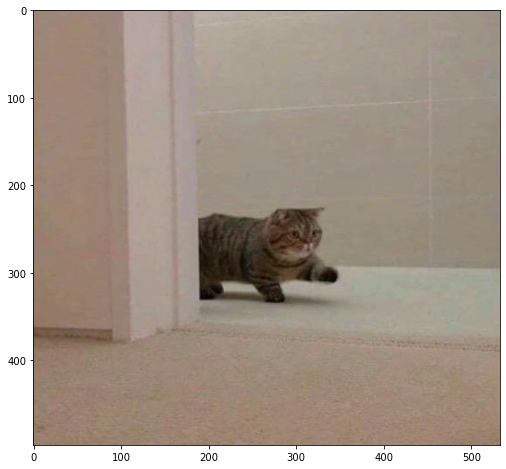

In [28]:
plt.figure(figsize=(16,8))
plt.imshow(low_image)
srgan_lr_hr = apply_srgan(low_image)
srgan_lr_hr_bicubic_image = cv2.resize(low_image, dsize = (low_image_shape[1]*4,low_image_shape[0]*4))

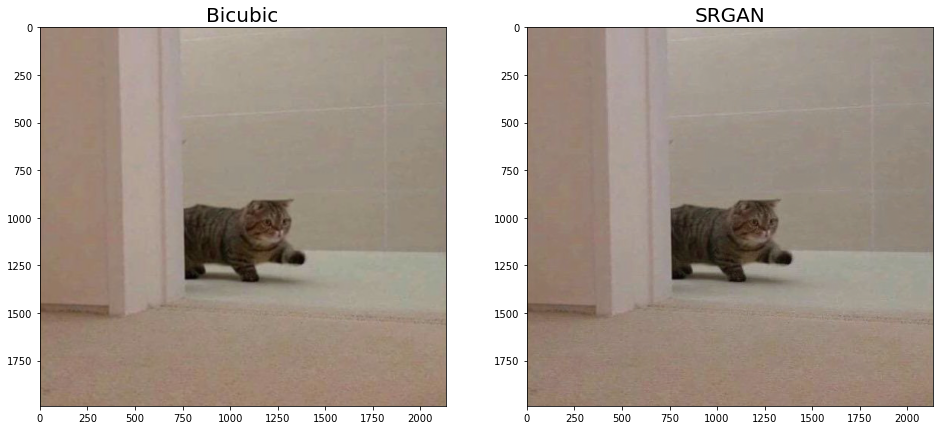

In [27]:
titles = ["Bicubic", "SRGAN"]
images = [srgan_lr_hr_bicubic_image, srgan_lr_hr]
plt.figure(figsize=(16,8))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

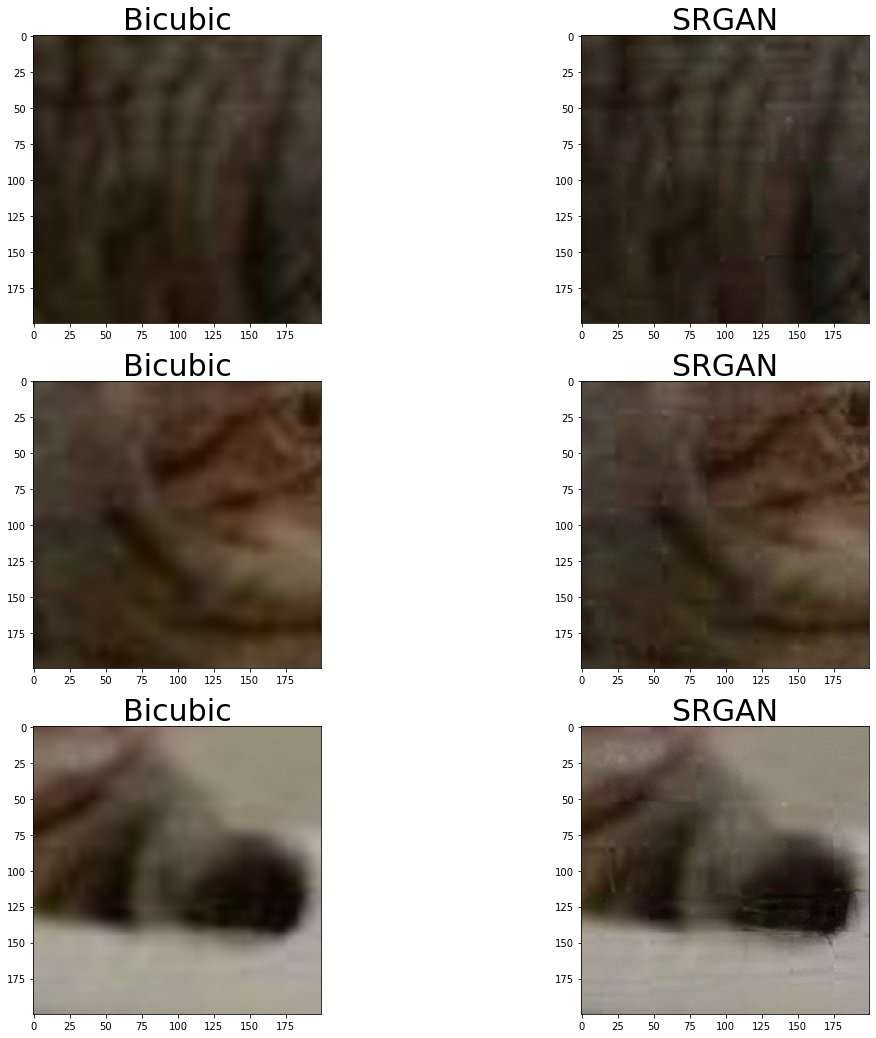

In [24]:
left_tops = [(1000,800), (1000,1000), (1100,1200)]

images = [srgan_lr_hr_bicubic_image, srgan_lr_hr]
point_crops=[]

def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

for left_top in left_tops:
    img1 = crop(images[0], left_top, 200, 200)
    img2 = crop(images[1] , left_top, 200, 200)
    point_crops.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(point_crops[i])
    plt.title(labels[i], fontsize=30)

## 결과
interpolation한 쪽은 원본 이미지의 노이즈를 최대한 없애면서 사진을 키울 수 있는 제일 간단한 방법으로 보인다. 원본 이미지의 노이즈를 가지고 있지만 원본 이미지 이상의 노이즈는 보이지 않는다. SRGAN의 경우 고양이의 무늬와 털의 디테일이 생겨났다. 

# 프로젝트 2
## 데이터 준비

In [12]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("./Downloads/book_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 22
frame 크기 : (215, 380, 3)


저화질 사진울 bicubic interpolation으로 처리하고 SRGAN을 적용한다. 

In [13]:
#비교를 위해 저화질 사진도 4배 확대한다. 
frames_ip = []
frames_sr = []
for frame in frames :
    ip_frame= cv2.resize(
    frame, 
    dsize=(frame.shape[1]*4,frame.shape[0]*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
    )
    frames_ip.append(ip_frame)
    sr_frame = apply_srgan(frame)
    frames_sr.append(sr_frame)

## 결과 시각화하기
비교를 위해 원본 - SRGAN - Interpolation을 차례대로 시각화해본다. 결과들을 시각화했는데 크기가 너무 커서 시각화는 생략하고 대신 별도의 파일로 같이 업로드한다. 

In [29]:
from IPython.display import Image as show_gif

In [30]:
import imageio

imageio.mimsave("sr_hr.gif", frames_sr)
imageio.mimsave("ip_hr.gif", frames_ip)

## 결과
Interpolation을 적용한 것은 경계가 또렷하지 않고 흐리다. 그리고 SRGAN을 적용한 것은 엣지로 인식되는 곳이 선명하게 나왔다. SRGAN을 적용하니까 확실히 gif가 선명해졌다.

# 회고
SRGAN이 다른 super resolution보다 결과가 좋아서 놀랐다. 특히 마지막의 gif 이미지가 자연스럽게 선명한 것에 더 놀랐다. 그렇지만 GAN은 여전히 어렵다. 